In [1]:
import numpy as np
import os

import copy

Set up variables for constants such as absolute datapaths and the desired valdiation fraction split.

In [2]:
#gnps
datapath = "G:\\Dev\\Data\\For Family\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\For Family\\GNPS Python Master\\Final Fingerprints.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

#gnps for family
gnps_for_family_datapath = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
fingerprints_for_family_gnps_path = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Fingerprints.txt"

#mibig
mibig_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\mibig_unique_smiles.txt"
mibig_families_path = "G:\\Dev\\Data\\Final Families.txt"
mibig_filtered_fingerprints_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered Mibig Fingerprints.tsv"
mibig_filtered_families_path = "G:\\Dev\\Data\\mibig_family.txt"

#npatlas
npatlas_smiles_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\NPAtlas_DB_last_version_filtered.txt"
npatlas_final_families_path = "G:\\Dev\\Data\\NPAtlas_Final_Families.txt"

#test
test_datapath = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Data.txt"
test_fingerprint_path = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Fingerprints.txt"

linked_fingerprints_path = "G:\\Dev\\Data\\Linked GNPS Fingerprints.tsv"
families_names_path = "G:\\Dev\\Data\\Family Legend.txt"

num_samples = 5770
num_smiles_families_samples = 1368
val_fraction = 0.1

Import methods from ultilities

In [3]:
from nn_evaluation_interface import plot_loss, compute_auc, evaluate, compute_predicted_family_proportion
from nn_files_load_interface import *
from nn_interface import simplified_fingerprint_model, simplified_family_model
from nn_training_splits_interface import train_diff_splits

C:\Users\CherWei\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load the data to variables

In [4]:
spectra = load_master_file(path=datapath)
fingerprints = load_fingerprints_master(path=fingerprints_path)

gnps_spectra = load_master_file(path=gnps_for_family_datapath)
gnps_fingerprints = load_fingerprints_master(path=fingerprints_for_family_gnps_path, number_of_rows=1)

mibig_fingerprints = load_fingerprints_master(path=mibig_fingerprints_path)
mibig_families = load_families_master(path=mibig_families_path)
mibig_filtered_fingerprints = load_fingerprints_master(path=mibig_filtered_fingerprints_path, number_of_rows=1)
mibig_filtered_families = load_families_master(path=mibig_filtered_families_path)

fingerprint_names = load_fingerprint_legend(path=fingerprints_names_path)
family_names = load_family_legend(path=families_names_path)

test_spectra = load_master_file(path=test_datapath)
test_fingerprint = load_fingerprints_master(path=test_fingerprint_path)

print("Done")

Done


The training/evaluation process

C:\Dev\nnpredict\Code\Python\nn_interface.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 5702 samples, validate on 634 samples
Epoch 1/100
5702/5702 [==============================] - 5s 917us/step - loss: 0.5197 - val_loss: 0.3222
Epoch 2/100
5702/5702 [==============================] - 2s 399us/step - loss: 0.1851 - val_loss: 0.1617
Epoch 3/100
5702/5702 [==============================] - 2s 430us/step - loss: 0.1228 - val_loss: 0.1329
Epoch 4/100
5702/5702 [==============================] - 5s 832us/step - loss: 0.1117 - val_loss: 0.1221
Epoch 5/100
5702/5702 [==============================] - 4s 639us/step - loss: 0.1073 - val_loss: 0.1165
Epoch 6/100
5702/5702 [==============================] - 4s 677us/step - loss: 0.1049 - val_loss: 0.1131
Epoch 7/100
5702/5702 [==============================] - 4s 704us/step - loss: 0.1033 - val_loss: 0.1106
Epoch 8/100
5702/5702 [==============================] - 4s 618us/step - loss: 0.1020 - val_loss: 0.1088
Epoch 9/100
5702/5702 [==============================] - 4s 645us/step - loss: 0.1011 - val_loss: 0.1073
Epoch 10

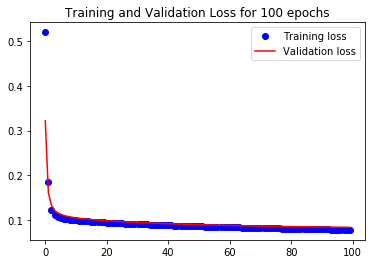

Done


In [5]:
# Training network 1 (exclude links)
epochs = 100
x_train_spectra = np.log(gnps_spectra+1)
x_train_fingerprints = gnps_fingerprints.values
x_test_spectra = np.log(test_spectra+1)

enc1 = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

actual = test_fingerprint.values
predicted = enc1.predict(x_test_spectra)

n1_stats, n1_perm_scores = compute_auc(320, actual, predicted)

In [ ]:
# Training network 2 (exclude links)
epochs = 100
x_train_fingerprints = mibig_filtered_fingerprints
x_train_families = mibig_filtered_families

enc2 = simplified_family_model(x_train_fingerprints.values, x_train_families.values, epochs=epochs)

Compute the families AUC in the fingerprint - family network by using predicted fingerprint

In [7]:
# using linked mibig-gnps as test set
x_train_spectra = load_master_file(path=test_datapath)
predicted = enc1.predict(x_train_spectra)

gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
x_train_families = load_families_master(gnps_families_path)
x_train_fingerprints = load_fingerprints_master(test_fingerprint_path, number_of_rows=1)

actual = x_train_families.values
predicted = enc2.predict(predicted) # using predicted fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0, 14, 0.67667173,   1.6) (1, 63, 0.56743177,   5.6)
 (2,  7, 0.61904762,  12.2) (3, 12, 0.42061404,  81.4)
 (4,  0, 0.        , 100. ) (5, 10, 0.44166667,  73.2)
 (6, 91, 0.58573409,   2. ) (7, 23, 0.64087928,   1.4)]

[[0.63487842 0.65159574 0.55091185 ... 0.41147416 0.51329787 0.32370821]
 [0.41521069 0.4897796  0.54402193 ... 0.55201553 0.51604431 0.47470595]
 [0.48131868 0.60879121 0.58827839 ... 0.61611722 0.4989011  0.65054945]
 ...
 [0.56666667 0.28854167 0.625      ... 0.56927083 0.49947917 0.375     ]
 [0.52648253 0.51861202 0.54657955 ... 0.47331947 0.51633502 0.48203148]
 [0.52963323 0.55635171 0.54700024 ... 0.4248239  0.51566675 0.50777265]]



In [8]:
compute_predicted_family_proportion(gnps_families_path, family_names, x_train_families.index, predicted)

{'Alkaloid': 14, 'NRP': 63, 'Terpene': 7, 'RiPP': 12, 'Nucleoside': 0, 'Saccharide': 10, 'Polyketide': 91, 'Other': 23}
Family, proportion guessed correctly, proportion missed
Alkaloid, 28.57142857142857, 5.339805825242718
NRP, 25.396825396825395, 22.29299363057325
Terpene, 14.285714285714285, 3.286384976525822
RiPP, 0.0, 0.0
Nucleoside no sample
Saccharide, 0.0, 0.0
Polyketide, 62.637362637362635, 47.286821705426355
Other, 13.043478260869565, 3.5532994923857872


Compute the families AUC in the fingerprint - family network by using true fingerprints

In [9]:
predicted = enc2.predict(x_train_fingerprints.values) # using true fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0, 14, 0.95744681,   0. ) (1, 63, 0.71953865,   0. )
 (2,  7, 0.72747253,   1.6) (3, 12, 0.90745614,   0. )
 (4,  0, 0.        , 100. ) (5, 10, 0.9171875 ,   0. )
 (6, 91, 0.95198495,   0. ) (7, 23, 0.73718727,   0. )]

[[0.64152736 0.5193769  0.62518997 ... 0.51101824 0.4481383  0.54711246]
 [0.49046477 0.49314834 0.44290282 ... 0.52295307 0.48030147 0.5081078 ]
 [0.58278388 0.73333333 0.62454212 ... 0.58205128 0.43589744 0.53076923]
 ...
 [0.48697917 0.5203125  0.46302083 ... 0.40078125 0.43984375 0.54322917]
 [0.498317   0.57128007 0.497921   ... 0.48500149 0.45752896 0.43114543]
 [0.49417051 0.4143794  0.45397134 ... 0.58379888 0.41984455 0.53497692]]



In [10]:
compute_predicted_family_proportion(gnps_families_path, family_names, x_train_families.index, predicted)

{'Alkaloid': 14, 'NRP': 63, 'Terpene': 7, 'RiPP': 12, 'Nucleoside': 0, 'Saccharide': 10, 'Polyketide': 91, 'Other': 23}
Family, proportion guessed correctly, proportion missed
Alkaloid, 28.57142857142857, 0.0
NRP, 34.92063492063492, 14.64968152866242
Terpene, 28.57142857142857, 5.164319248826291
RiPP, 25.0, 0.0
Nucleoside no sample
Saccharide, 40.0, 0.0
Polyketide, 87.91208791208791, 33.33333333333333
Other, 26.08695652173913, 2.030456852791878


Use a bigger test dataset (the whole MIBiG - 1813 samples)

In [11]:
# using mibig all as test dataset
x_train_fingerprints = mibig_fingerprints
x_train_families = mibig_families

actual = x_train_families.values
predicted = enc2.predict(x_train_fingerprints.values) # using true fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0,  90, 0.97726193,  0. ) (1, 505, 0.91723844,  0. )
 (2, 131, 0.97507483,  0. ) (3,  72, 0.98806566,  0. )
 (4,   1, 0.36514523, 70.2) (5, 103, 0.97257859,  0. )
 (6, 722, 0.94090744,  0. ) (7, 189, 0.90664194,  0. )]

[[0.52821174 0.48218701 0.49755179 ... 0.49547613 0.45286989 0.53128224]
 [0.5061466  0.50264026 0.49309348 ... 0.51179815 0.49401947 0.49233882]
 [0.47892933 0.49305958 0.49462285 ... 0.50692882 0.54400914 0.48169911]
 ...
 [0.47137584 0.48255461 0.57166696 ... 0.49147235 0.53282839 0.55850526]
 [0.51535199 0.47943261 0.47413984 ... 0.47324864 0.48801987 0.48528417]
 [0.50537933 0.48186842 0.52425114 ... 0.46736232 0.47150302 0.50251512]]



In [12]:
compute_predicted_family_proportion(mibig_families_path, family_names, x_train_families.index, predicted)

{'Alkaloid': 90, 'NRP': 505, 'Terpene': 131, 'RiPP': 72, 'Nucleoside': 1, 'Saccharide': 103, 'Polyketide': 722, 'Other': 189}
Family, proportion guessed correctly, proportion missed
Alkaloid, 46.666666666666664, 0.6964596633778294
NRP, 63.366336633663366, 5.045871559633028
Terpene, 74.80916030534351, 0.8323424494649228
RiPP, 63.888888888888886, 0.402067777139575
Nucleoside, 0.0, 0.0
Saccharide, 19.41747572815534, 0.11695906432748539
Polyketide, 83.5180055401662, 8.340971585701192
Other, 48.67724867724868, 2.0935960591133003


Get common fingerprint for each family

In [15]:
family_common_fingerprint_path = "G:\\Dev\\Data\\family_common_substructures.txt"
family_substructure_auc_path = "G:\\Dev\\Data\\family_substructure_auc.txt"
family_substructure_auc = {}
n1_stats = list(n1_stats)

with open(family_common_fingerprint_path, 'r') as f:
    for line in f:
        family, bit_name, occurrence, occurence_other, diff = line.split("  ")
        if family not in family_substructure_auc:
            family_substructure_auc[family] = {}
        family_substructure_auc[family][bit_name] = n1_stats[fingerprint_names.index(bit_name)][2]

with open(family_substructure_auc_path, 'w') as f:
    for key, details in family_substructure_auc.items():
        for substructure, auc in details.items():
            f.write(key + "," + substructure + "," + str(round(auc,2)) + "\n")

print("Done")

Done


In [ ]:
# Training network 1 (include links)
epochs = 100
x_train_spectra = np.log(spectra+1)
x_train_fingerprints = fingerprints.values

enc1 = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

C:\Dev\nnpredict\Code\Python\nn_interface.py:157: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 1231 samples, validate on 137 samples
Epoch 1/100
1231/1231 [==============================] - 1s 902us/step - loss: 0.5226 - val_loss: 0.3818
Epoch 2/100
1231/1231 [==============================] - 1s 451us/step - loss: 0.3585 - val_loss: 0.3259
Epoch 3/100
1231/1231 [==============================] - 1s 635us/step - loss: 0.3297 - val_loss: 0.3123
Epoch 4/100
1231/1231 [==============================] - 1s 692us/step - loss: 0.3170 - val_loss: 0.3045
Epoch 5/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.3073 - val_loss: 0.2983
Epoch 6/100
1231/1231 [==============================] - 1s 634us/step - loss: 0.2990 - val_loss: 0.2928
Epoch 7/100
1231/1231 [==============================] - 1s 553us/step - loss: 0.2917 - val_loss: 0.2878
Epoch 8/100
1231/1231 [==============================] - 1s 469us/step - loss: 0.2852 - val_loss: 0.2833
Epoch 9/100
1231/1231 [==============================] - 0s 395us/step - loss: 0.2793 - val_loss: 0.2792
Epoch 10

Epoch 78/100
1231/1231 [==============================] - 1s 555us/step - loss: 0.1653 - val_loss: 0.2089
Epoch 79/100
1231/1231 [==============================] - 1s 531us/step - loss: 0.1646 - val_loss: 0.2086
Epoch 80/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.1639 - val_loss: 0.2084
Epoch 81/100
1231/1231 [==============================] - 1s 528us/step - loss: 0.1631 - val_loss: 0.2082
Epoch 82/100
1231/1231 [==============================] - 1s 504us/step - loss: 0.1624 - val_loss: 0.2080
Epoch 83/100
1231/1231 [==============================] - 1s 524us/step - loss: 0.1617 - val_loss: 0.2078
Epoch 84/100
1231/1231 [==============================] - 1s 501us/step - loss: 0.1610 - val_loss: 0.2076
Epoch 85/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.1603 - val_loss: 0.2074
Epoch 86/100
1231/1231 [==============================] - 1s 531us/step - loss: 0.1596 - val_loss: 0.2072
Epoch 87/100
1231/1231 [======================

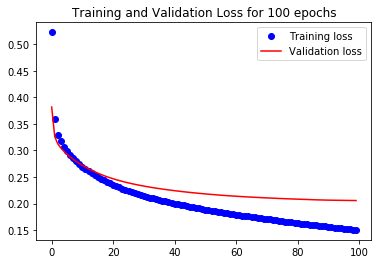

In [12]:
# Training network 2 (include links)
epochs = 100
x_train_fingerprints = mibig_fingerprints
x_train_families = mibig_families

enc2 = simplified_family_model(x_train_fingerprints.values, x_train_families.values, epochs=epochs)

In [ ]:
mibig_links_path = "G:\\Dev\\Data\\mibig_gnps_links_q3_loose.csv"
mibig_family_path = "G:\\Dev\\Data\\mibig_family\\gene_family.txt"
mibig_gnps_df = pd.read_csv(mibig_links_path, sep=",")

mibig_gnps_dict = {}
mibig_families = {}
mibig_families_count = {}

for index, row in mibig_gnps_df.iterrows():
    if row["gnps_id"] not in mibig_gnps_dict:
        mibig_gnps_dict[row["gnps_id"]] = set()
    mibig_gnps_dict[row["gnps_id"]].add(row["#mibig_id"])

with open(mibig_family_path, 'r') as f:
    for line in f:
        mibig_id, family = line.split("  ")
        if mibig_id not in mibig_families:
            mibig_families[mibig_id] = []
        mibig_families[mibig_id].append(family[:-1])
        
probability_report_path = "G:\\Dev\\Data\\gnps_prediction_report.csv"
families = ["Alkaloid", "NRP", "Terpene", "RiPP", "Nucleoside", "Saccharide", "Polyketide", "Other"]
true_family_counter = {}
family_correct_counter = {}

for family in families:
    true_family_counter[family] = 0
    family_correct_counter[family] = 0

with open(probability_report_path, 'w') as f:
    f.write("#mibig_id,gnps_id,Alkaloid,NRP,Terpene,RiPP,Nucleoside,Saccharide,Polyketide,Other,True Label\n")

with open(probability_report_path, 'a') as f:    
    for index, probabilities in enumerate(predicted):
        temp = copy.deepcopy(probabilities).tolist()
        gnps_id = x_train_fingerprints.index[index]
        prob_string = ",".join(map(str, probabilities))
        for mibig_id in mibig_gnps_dict[gnps_id]:
            true_labels = []
            max_indexes = []
            for true_family in mibig_families[mibig_id]:
                true_labels.append(true_family)
                max_index = temp.index(max(temp))
                max_indexes.append(max_index)
                temp.remove(temp[max_index])
                true_family_counter[true_family] += 1
                f.write(mibig_id + "," + gnps_id + "," + prob_string + "," + true_family + "\n")
            for index in max_indexes:
                if families[index] in true_labels:
                    family_correct_counter[families[index]] += 1
    
prediction_comparison_report_path = "G:\\Dev\\Data\\prediction_comparison_report.txt"
with open(prediction_comparison_report_path, 'w') as f:
    f.write("family,matched,actual,proportion\n")

with open(prediction_comparison_report_path, 'a') as f:
    for family in family_correct_counter:
        matched = family_correct_counter[family]
        actual = true_family_counter[family]
        proportion = 0
        if actual != 0:
            proportion = matched / actual
        f.write(family + "," + str(matched) + "," + str(actual) + "," + str(proportion*100) + "\n")
    
print("Done")

In [ ]:
filepath = "G:\\Dev\\Data\\saved_spectrum_fingerprint_non_binary_model.h5"
enc1.save(filepath)

filepath = "G:\\Dev\\Data\\saved_fingerprint_families_non_binary_model.h5"
enc2.save(filepath)